# Imports 

In [1]:
## Essential Imports: 
import os
import numpy as np
import qp
import tables_io
from pathlib import Path 
from pzflow.examples import get_galaxy_data
import ceci

## RAIL-Specific Imports: 
import rail

# old : from rail.creation.degradation import LSSTErrorModel, InvRedshiftIncompleteness


from rail.creation.degradation.lsst_error_model import LSSTErrorModel
from rail.creation.degradation.spectroscopic_degraders import InvRedshiftIncompleteness

import rail.creation 
import rail.creation.engines
from rail.creation.engines.flowEngine import FlowModeler, FlowCreator, FlowPosterior
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

# old : from rail.estimation.algos.flexzboost import Inform_FZBoost, FZBoost

from rail.estimation.algos.train_z import TrainZEstimator, TrainZInformer
from rail.estimation.algos.cmnn import Inform_CMNNPDF, CMNNPDF
from rail.estimation.algos.gpz import GPzInformer, GPzEstimator 
from rail.estimation.algos.pzflow_nf import PZFlowInformer, PZFlowEstimator 
from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator  


from rail.evaluation.evaluator import Evaluator


## Data Storage: 
DS = RailStage.data_store
DS.__class__.allow_overwrite = True


### CMNN, PZFlow, FlexZBoost, GPZ, trainz for control

In [2]:
#from rail.stages import *
#rail.stages.import_and_attach_all()
#for val in RailStage.pipeline_stages.values():
#    print(val[0])

# Model

In [3]:
def makeModel():
    #path to access the data 
    DATA_DIR =  Path().resolve() / "data"
    DATA_DIR.mkdir(exist_ok=True)

    catalog_file = DATA_DIR / "base_catalog.pq"

    bands = ['u','g','r','i','z','y']
    band_dict = {band:f'mag_{band}_lsst' for band in bands}
    # band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}
    # band_dict_err = {f'mag_err_{band}_lsst' for band in bands}
    
    #array of galaxies w/ 7 attributes for each: redshift & ugrizy
    catalog = get_galaxy_data().rename(band_dict, axis=1) 

    #turns array into a table 
    tables_io.write(catalog, str(catalog_file.with_suffix("")), catalog_file.suffix[1:])

    catalog_file = str(catalog_file)
    flow_file = str(DATA_DIR / "trained_flow.pkl")

    print(flow_file)

    #we set up the stage 
    flow_modeler_params = {
        "name": "flow_modeler",
        "input": catalog_file,
        "model": flow_file,
        "seed": 0,
        "phys_cols": {"redshift": [0, 3]},
        "phot_cols": {
            "mag_u_lsst": [17, 35],
            "mag_g_lsst": [16, 32],
            "mag_r_lsst": [15, 30],
            "mag_i_lsst": [15, 30],
            "mag_z_lsst": [14, 29],
            "mag_y_lsst": [14, 28],
        },
        "calc_colors": {"ref_column_name": "mag_i_lsst"},
    }
    flow_modeler = FlowModeler.make_stage(**flow_modeler_params)
    # flow_modeler.fit_model()
    return flow_modeler, flow_file ##.get_handle("model")

In [4]:
modelData, flow_file = makeModel() 

/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl


# Make Training Set and Test Set 

In [35]:
def spec_trainSet(ntrain, seed):
    data = FlowCreator.make_stage(
            name = 'spec_train_set',
            model = flow_file,
            n_samples = ntrain,
            seed = seed 
    )
    return data 

def invz_trainSet(ntrain, seed):
    data = FlowCreator.make_stage(
            name = 'invz_train_set',
            model = flow_file,
            n_samples = ntrain,
            seed = seed 
    )
    return data 


spec_train_data = spec_trainSet(1000000, 17)
invz_train_data = invz_trainSet(100000, 17)

In [6]:
def testSet(ntest, seed):
    data = FlowCreator.make_stage(
            name = 'test_set',
            model = flow_file,
            n_samples = ntest,
            seed = seed 
    )
    return data #.sample(ntest, seed)

test_data = testSet(10000, 39)

# Degraders

## Inverse Redshift Incompleteness

In [7]:
def invRedshift(pivot = 1.0):
    assert type(pivot) == float 
    degr = InvRedshiftIncompleteness.make_stage(
        name = 'inv_redshift',
        pivot_redshift = pivot
    )
    return degr 

pivot_ls = [1.0, 1.4]

## LSST Error 

In [8]:
bands = ['u','g','r','i','z','y']
band_dict = {band:f'mag_{band}_lsst' for band in bands}

def lsstError(dict, seed): 
    deg = LSSTErrorModel.make_stage(
        name='lsst_error',
        renameDict= dict, 
        ndFlag=np.nan,
        seed=seed,
    )
    return deg 

def lsstError_0(dict, seed): 
    deg = LSSTErrorModel.make_stage(
        name='lsst_error_0',
        renameDict= dict, 
        ndFlag=np.nan,
        seed=seed,
        #nYrObs = 1000000,
        #tvis = 1000000,
        #sigmaSys= 0.000
    )
    return deg 

## Quantity Cuts 

In [13]:
## write a dictionary with the different bands and magnitudes you want

def quantCuts(band, mag):
    quantity_cut = QuantityCut.make_stage(
        name='quantity_cut',    
        cuts={'mag_i_lsst': 25.0},
    )

In [14]:
qcuts_dict = {'mag_u_lsst': [...], 
              'mag_g_lsst': [...], 
              'mag_r_lsst': [...], 
              'mag_i_lsst': [...], 
              'mag_z_lsst': [...], 
              'mag_y_lsst': [...] }

## Survey-Based Degraders

In [9]:
from rail.creation.degradation.spectroscopic_selections import *

def specSelectBOSS(ntrain):
    degr = SpecSelection_BOSS.make_stage(
        name = 'specselection_boss',
        N_tot = ntrain
    )
    return degr 

def specSelectDEEP2(ntrain):
    degr = SpecSelection_DEEP2.make_stage(
        name = 'specselection_deep2',
        N_tot = ntrain
    )
    return degr 

def specSelectGAMA(ntrain):
    degr = SpecSelection_GAMA.make_stage(
        name = 'specselection_gama',
        N_tot = ntrain
    )
    return degr 

def specSelectHSC(ntrain):
    degr = SpecSelection_HSC.make_stage(
        name = 'specselection_HSC',
        N_tot = ntrain
    )
    return degr 

def specSelectVVDSf02(ntrain):
    degr = SpecSelection_VVDSf02.make_stage(
        name = 'specselection_VVDSf02',
        N_tot = ntrain
    )
    return degr 

def specSelectzCOSMOS(ntrain):
    degr = SpecSelection_zCOSMOS.make_stage(
        name = 'specselection_zCOSMOS',
        N_tot = ntrain
    )
    return degr 

In [10]:
spec_dict = {'BOSS': specSelectBOSS, 
             'DEEP2': specSelectDEEP2, 
             'GAMA': specSelectGAMA,
             'HSC': specSelectHSC, 
             'VVDSf02': specSelectVVDSf02, 
             'zCOSMOS': specSelectzCOSMOS } 

# Posteriors 

In [11]:
# def getPosts(data, model, grid):
#     posts = FlowPosterior.make_stage(
#         name='get_posts'+str(data), 
#         column='redshift',
#         grid = grid,
#         model = model,
#         data = data
#     )
#     return posts #posts.get_posterior(data, column = 'redshift')

In [12]:
# def makeGrid(zmin, zmax, nbins):
#     import numpy as np
#     grid = np.linspace(zmin, zmax, nbins + 1)
#     return grid 

In [13]:
# grid = makeGrid(0, 2.5, 100)

Only run if you need output_orig_train_posts

In [14]:
# flow_post_orig_train = FlowPosterior.make_stage(name='orig_train_posts', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 101),
#                                              model=flow_file,
#                                              data = orig_train)

# orig_train_pdfs = flow_post_orig_train.get_posterior(orig_train, column='redshift')

Only run if you need output_deg_train_posts ** rerun this cell!! 

In [15]:
# flow_post_deg_train = FlowPosterior.make_stage(name='deg_train_posts', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 101),
#                                              model=flow_file,
#                                              err_samples = 0,
#                                              data = deg_train)



# deg_train_pdfs = flow_post_deg_train.get_posterior(deg_train, column='redshift')

Only run if you need output_orig_test_posts

In [16]:
# flow_post_orig_test = FlowPosterior.make_stage(name='orig_test_posts', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 101),
#                                              model=flow_file,
#                                              data = orig_test)

# orig_test_pdfs = flow_post_orig_test.get_posterior(orig_test, column='redshift')

Only run if you need output_deg_test_posts

In [110]:
# posts_data = test_data.sample(10000, 39)

lsstErr = lsstError(band_dict, 172)
lsstErr.connect_input(test_data)

posts_data = lsstErr(test_data.sample(10000, 17), seed=172)

posts_data

Inserting handle into data store.  output_test_set: inprogress_output_test_set.pq, test_set
Inserting handle into data store.  output_lsst_error: inprogress_output_lsst_error.pq, lsst_error


In [111]:
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test")

lsstErr_testSet_posts = FlowPosterior.make_stage(name='lsstErr_testSet_posts', 
                                             column='redshift',
                                             grid = np.linspace(0, 2.5, 101),
                                             model=flow_file,
                                             data = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error (for posts).pq"
)

# lsstErr_test_pdfs = lsstErr_testSet_posts.get_posterior(lsstErr_deg_data, column='redshift')

# post_file = .read("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error (for posts).pq")
lsstErr_test_pdfs = lsstErr_testSet_posts.get_posterior(posts_data, column = 'redshift')

Inserting handle into data store.  output_lsstErr_testSet_posts: inprogress_output_lsstErr_testSet_posts.hdf5, lsstErr_testSet_posts


/Users/alicec03/miniforge3/envs/rail---new/lib/python3.11/site-packages/qp/interp_pdf.py:83: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:,-1]).T


In [117]:
import h5py
import pandas as pd

file = h5py.File("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsstErr_testSet_posts.hdf5", 'r')
print(file['meta'].keys())

table = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error (for posts).pq")

table

<KeysViewHDF5 ['pdf_name', 'pdf_version', 'xvals']>


,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,0.520948,27.374494,0.211640,25.684959,0.070899,25.954994,0.060779,NaN,NaN,24.964686,0.148859,25.701503,0.126073
1,0.970512,25.861015,0.056888,24.887539,0.034959,25.388159,0.036758,26.231575,0.232690,24.368417,0.088593,24.499278,0.043682
2,1.320268,26.796911,0.129428,25.527806,0.061683,26.321098,0.084024,29.770850,2.144325,24.540326,0.103018,25.117785,0.075592
3,1.035288,26.489168,0.099005,25.401373,0.055136,25.877703,0.056750,26.562947,0.304758,24.466978,0.096606,24.676015,0.051101
4,1.599862,26.402639,0.091771,26.180933,0.109677,26.393691,0.089570,26.002167,0.192183,25.819267,0.303473,25.547411,0.110259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.188424,27.550561,0.244919,26.616389,0.159804,27.090805,0.164031,26.984455,0.423752,25.373730,0.210577,25.574843,0.112928
9996,0.678350,25.585286,0.044558,24.643624,0.028209,25.269635,0.033105,25.792986,0.161001,24.010129,0.064557,24.336864,0.037828
9997,0.364240,26.648873,0.113821,25.549677,0.062891,25.757072,0.050986,27.439980,0.592538,25.267265,0.192575,25.272837,0.086671
9998,0.960942,26.820437,0.132087,24.232563,0.019789,25.134620,0.029399,27.594492,0.660157,23.121956,0.029412,23.430820,0.017288


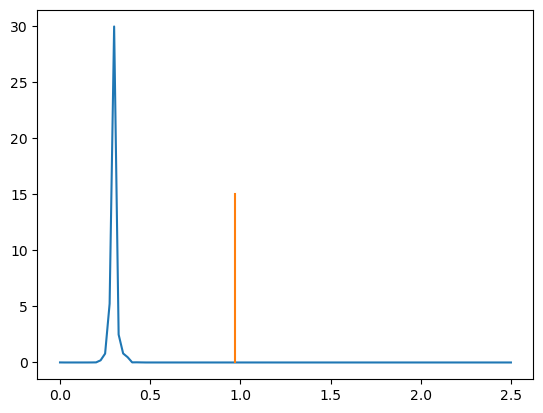

In [120]:
import matplotlib.pyplot as plt

plt.plot(file['meta']['xvals'][0], file['data']['yvals'][1])
plt.plot(table['redshift'][1] * np.ones(len(file['meta']['xvals'][0])), np.linspace(0, 15, len(file['meta']['xvals'][0])))

# Make tables

In [63]:
bands = ['u','g','r','i','z','y']
band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

def colRemapper_1(dict):
    col_remap = ColumnMapper.make_stage(
    name='col_remapper_1', 
    columns=dict,
    )
    return col_remap

def colRemapper_2(dict):
    col_remap = ColumnMapper.make_stage(
    name='col_remapper_2', 
    columns=dict,
    )
    return col_remap

def tableConverter():
    table_conv = TableConverter.make_stage(
    name='table_conv', 
    output_format='numpyDict',
    )
    return table_conv

# Inform & Estimate

In [18]:
def informTrainZ():
    inf = TrainZInformer.make_stage(
    name = 'inform_TrainZ',
    model = 'trainz.pkl',
    hdf5_groupname=""
    )
    return inf

def estimateTrainZ(info):
    est = TrainZEstimator.make_stage(
    name = 'estimate_TrainZ',
    model = 'trainz.pkl', 
    hdf5_groupname=""
    )
    return est

In [19]:
# help(rail.estimation.algos.cmnn)#Inform_CMNNPDF)

In [20]:
def informCMNN():
    inf = Inform_CMNNPDF.make_stage(
    name = 'inform_CMNN',
    model = 'cmnn.pkl',
    hdf5_groupname=""
    # config_options = {'err_bands': ['mag_err_u_lsst', 
    #                                 'mag_err_g_lsst'
    #                                 'mag_err_r_lsst'
    #                                 'mag_err_i_lsst'
    #                                 'mag_err_z_lsst'
    #                                 'mag_err_y_lsst'] }
    )
    return inf

def estimateCMNN(info):
    est = CMNNPDF.make_stage(
    name = 'estimate_CMNN',
    model = 'cmnn.pkl', 
    hdf5_groupname=""
    )
    return est

In [21]:
def informGPz():
    inf = GPzInformer.make_stage(
    name = 'inform_GPz',
    model = 'gpz.pkl',
    hdf5_groupname=""
    # config_options = {'err_bands': ['mag_err_u_lsst', 
    #                                 'mag_err_g_lsst'
    #                                 'mag_err_r_lsst'
    #                                 'mag_err_i_lsst'
    #                                 'mag_err_z_lsst'
    #                                 'mag_err_y_lsst'] }

    )
    return inf

def estimateGPz(info):
    est = GPzEstimator.make_stage(
    name = 'estimate_GPz',
    model = 'gpz.pkl', 
    hdf5_groupname=""
    )
    return est

In [22]:
def informPZFlow():
    inf = PZFlowInformer.make_stage(
    name = 'inform_PZFlow',
    model = 'pzflow.pkl',
    hdf5_groupname=""
    )
    return inf

def estimatePZFlow(info):
    est = PZFlowEstimator.make_stage(
    name = 'estimate_PZFlow',
    model = 'pzflow.pkl', 
    hdf5_groupname=""
    )
    return est

In [23]:
PZFlowInformer.config_options

{'output_mode': <ceci.config.StageParameter at 0x16906bcd0>,
 'hdf5_groupname': str,
 'save_train': True,
 'zmin': <ceci.config.StageParameter at 0x1771aa750>,
 'zmax': <ceci.config.StageParameter at 0x1771aa790>,
 'nzbins': <ceci.config.StageParameter at 0x1771aa7d0>,
 'flow_seed': <ceci.config.StageParameter at 0x1771aa810>,
 'ref_column_name': <ceci.config.StageParameter at 0x1771aa850>,
 'column_names': <ceci.config.StageParameter at 0x1771aa890>,
 'mag_limits': <ceci.config.StageParameter at 0x1771aa8d0>,
 'include_mag_errors': <ceci.config.StageParameter at 0x1771aa910>,
 'error_names_dict': <ceci.config.StageParameter at 0x1771aa950>,
 'n_error_samples': <ceci.config.StageParameter at 0x1771aa990>,
 'soft_sharpness': <ceci.config.StageParameter at 0x1771aa9d0>,
 'soft_idx_col': <ceci.config.StageParameter at 0x1771aaa10>,
 'redshift_column_name': <ceci.config.StageParameter at 0x1771aaa50>,
 'num_training_epochs': <ceci.config.StageParameter at 0x1771aaa90>}

In [24]:
def informFZBoost():
    info = FlexZBoostInformer.make_stage(
    name ='inform_FZBoost', 
    model ='fzboost.pkl', 
    hdf5_groupname='',
    )
    return info

def estimateFZBoost(info):
    est = FlexZBoostEstimator.make_stage(
    name='estimate_FZBoost', 
    nondetect_val=np.nan,
    model= 'fzboost.pkl', 
    hdf5_groupname='',
    # aliases=dict(input='test_data', output='fzboost_estim'),
    nzbins = 100 
    )
    return est 

In [25]:
inf_est_dict = {'TrainZ': [informTrainZ, estimateTrainZ],
               'CMNN': [informCMNN, estimateCMNN], 
               'GPz': [informGPz, estimateGPz], 
               'PZFlow': [informPZFlow, estimatePZFlow], 
               'FZBoost': [informFZBoost, estimateFZBoost]}

In [26]:
# 'invz': invRedshift,

spec_dict = {'BOSS': specSelectBOSS, 
             'DEEP2': specSelectDEEP2, 
             'GAMA': specSelectGAMA,
             'HSC': specSelectHSC, 
             'VVDSf02': specSelectVVDSf02, 
             'zCOSMOS': specSelectzCOSMOS } 

inf_est_dict = {'TrainZ': [informTrainZ, estimateTrainZ],
               'CMNN': [informCMNN, estimateCMNN], 
               'GPz': [informGPz, estimateGPz], 
               'PZFlow': [informPZFlow, estimatePZFlow], 
               'FZBoost': [informFZBoost, estimateFZBoost] }

In [58]:
# import ceci 

# pr = ceci.Pipeline.read(path_lst_1[0])#parent_dir+directory+"/invz=0.33672517538070684_lsstErr_pzflow.yml")
# pr.run()

# ## 1) terminal: go to path up to invz_lsstErr_pzflow, then run these 2 lines 
# ## 2)  make list/txt file with list of paths to files made by big F

# ## do 1) 
# ## open virtual env
# ## python 
# ## import ceci 
# ## run the 2 lines of code above 


# ### at the end we can put this into a .py file that we can run at the command line 

# ## %cd ? 

In [59]:
## more config parameters/better config parameters
## have to give path above to estimator model instead of get_handle('model')
## fix truncated parameter printing in help(...)

# Big F's

In [121]:
## for inverse redshift incompleteness:

pivot_ls = [1.0, 1.4, 'control'] 

name_ls = ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS']

## TrainZ

In [28]:
## HAS BEEN RUN! ##

In [132]:
def bigF0(degrader, name, pathname, ntrain, ntest, seed1, seed2, seed3, nbins, invzparam):
    
    ##things you need
    #grid = makeGrid(0, 2.5, nbins) 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    # modelData = makeModel()
    
    # trainData = trainSet(ntrain, seed1)

    if degrader == invRedshift:
        if invzparam == 'control':
            pass
        else:
            deg = degrader(invzparam)
    else:
        deg = degrader(ntrain) 

    # print('degrader is: '+str(deg))
    
    # testData = testSet(ntest, seed2)

    #lsstErr = lsstError(band_dict, 172)
    lsstErr_0 = lsstError_0(band_dict, seed1)

    infTrainZ = informTrainZ()
    estTrainZ = estimateTrainZ(infTrainZ)

    ##pipeline and yml
    pipe = ceci.Pipeline.interactive()
    stages = [
        #invz_train_data, 
        #spec_train_data,
        #deg, 
        lsstErr_0,
        test_data, 
        lsstErr,  
        infTrainZ, 
        estTrainZ]
    
    if degrader == invRedshift:
        stages.append(invz_train_data)
    else:
        stages.append(spec_train_data)

    if invzparam != 'control':
        stages.append(deg)


    for stage in stages:
        pipe.add_stage(stage)
    
    
    if degrader == invRedshift: 
        if invzparam =='control':
            pass
        else:
            deg.connect_input(invz_train_data)
    else:
        deg.connect_input(spec_train_data)

    #lsstErr.connect_input(test_data)
    if invzparam == 'control':
        lsstErr_0.connect_input(invz_train_data)
    else:
        lsstErr_0.connect_input(deg)

    infTrainZ.connect_input(lsstErr_0) 
    estTrainZ.connect_input(infTrainZ, inputTag = 'model')
    estTrainZ.connect_input(lsstErr, inputTag = 'input') ## trucated out of docs :(

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, "% s_lsstErr_pzflow.yml" % name)
    pipe.save(outpath)
    return outpath 

### Specs

In [37]:
##run 

path_lst_0 = []
directory_0 = "specSelection_lsstErr_TrainZ"
parent_dir_0 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_0 = os.path.join(parent_dir_0, directory_0)
os.makedirs(path_0, exist_ok=True)

In [38]:
for key in spec_dict:
    path_lst_0.append(bigF0(spec_dict[key], key, path_0, 1000000, 10000, 17, 39, 172, 10, 0))

degrader is: Applying the BOSS selection.
Inserting handle into data store.  output_spec_train_set: inprogress_output_spec_train_set.pq, spec_train_set
degrader is: Applying the DEEP2 selection.
Inserting handle into data store.  output_specselection_deep2: inprogress_output_specselection_deep2.pq, specselection_deep2
degrader is: Applying the GAMA selection.
Inserting handle into data store.  output_specselection_gama: inprogress_output_specselection_gama.pq, specselection_gama
degrader is: Applying the HSC selection.
Inserting handle into data store.  output_specselection_HSC: inprogress_output_specselection_HSC.pq, specselection_HSC
degrader is: Applying the VVDSf02 selection.
Inserting handle into data store.  output_specselection_VVDSf02: inprogress_output_specselection_VVDSf02.pq, specselection_VVDSf02
degrader is: Applying the zCOSMOS selection.
Inserting handle into data store.  output_specselection_zCOSMOS: inprogress_output_specselection_zCOSMOS.pq, specselection_zCOSMOS


In [39]:
out_dir_0 = "outputs"
out_parent_dir_0 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ"
path_outs_0 = os.path.join(out_parent_dir_0, out_dir_0)
os.makedirs(path_outs_0, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs")

ind = 0
for i in path_lst_0:
    if ind <= 5:
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs")
        dir_0 = name_ls[ind]
        parent_0 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs"
        outpath_0 = os.path.join(parent_0, dir_0)
        os.makedirs(outpath_0, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/"+dir_0)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


# import pandas as pd
# df2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_TEST2/outputs/output_specselection_boss.pq")


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/BOSS_lsstErr_pzflow_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/BOSS_lsstErr_pzflow_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing spec_train_set
Command is:
OMP_NUM_THREADS=

In [102]:
import pandas as pd
df_BOSS = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/BOSS/output_specselection_boss.pq")
df_DEEP2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/DEEP2/output_specselection_deep2.pq")
df_GAMA = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/GAMA/output_specselection_gama.pq")
df_HSC = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/HSC/output_specselection_hsc.pq")
df_VVDSf02 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/VVDSf02/output_specselection_VVDSf02.pq")
df_zCOSMOS = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/zCOSMOS/output_specselection_zCOSMOS.pq")

print(len(df_BOSS))
print(len(df_DEEP2))
print(len(df_GAMA))
print(len(df_HSC))
print(len(df_VVDSf02))
print(len(df_zCOSMOS))

1133
52105
4567
23902
137241
57704


In [86]:
import h5py
import pandas as pd

file = h5py.File("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsstErr_testSet_posts.hdf5", 'r')
file['meta'].keys()


df1 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error.pq")
df2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/BOSS/output_lsst_error.pq")
df3 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/DEEP2/output_lsst_error.pq")
df4 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/GAMA/output_lsst_error.pq")

df5 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_lsst_error.pq")

df6 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/outputs/BOSS/output_lsst_error.pq")
df7 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs/HSC/output_lsst_error.pq")

In [87]:
df7 == df5

,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,True,True,True,True,True,True,True,False,False,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,True,True,True,True,True,True,True,True,True,True,True,True,True
9996,True,True,True,True,True,True,True,True,True,True,True,True,True
9997,True,True,True,True,True,True,True,True,True,True,True,True,True
9998,True,True,True,True,True,True,True,True,True,True,True,True,True


In [59]:
df5

,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,0.520948,27.374494,0.211640,25.684959,0.070899,25.954994,0.060779,NaN,NaN,24.964686,0.148859,25.701503,0.126073
1,0.970512,25.861015,0.056888,24.887539,0.034959,25.388159,0.036758,26.231575,0.232690,24.368417,0.088593,24.499278,0.043682
2,1.320268,26.796911,0.129428,25.527806,0.061683,26.321098,0.084024,29.770850,2.144325,24.540326,0.103018,25.117785,0.075592
3,1.035288,26.489168,0.099005,25.401373,0.055136,25.877703,0.056750,26.562947,0.304758,24.466978,0.096606,24.676015,0.051101
4,1.599862,26.402639,0.091771,26.180933,0.109677,26.393691,0.089570,26.002167,0.192183,25.819267,0.303473,25.547411,0.110259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.188424,27.550561,0.244919,26.616389,0.159804,27.090805,0.164031,26.984455,0.423752,25.373730,0.210577,25.574843,0.112928
9996,0.678350,25.585286,0.044558,24.643624,0.028209,25.269635,0.033105,25.792986,0.161001,24.010129,0.064557,24.336864,0.037828
9997,0.364240,26.648873,0.113821,25.549677,0.062891,25.757072,0.050986,27.439980,0.592538,25.267265,0.192575,25.272837,0.086671
9998,0.960942,26.820437,0.132087,24.232563,0.019789,25.134620,0.029399,27.594492,0.660157,23.121956,0.029412,23.430820,0.017288


In [51]:
df3

,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,0.520948,27.374494,0.211640,25.684959,0.070899,25.954994,0.060779,NaN,NaN,24.964686,0.148859,25.701503,0.126073
1,0.970512,25.861015,0.056888,24.887539,0.034959,25.388159,0.036758,26.231575,0.232690,24.368417,0.088593,24.499278,0.043682
2,1.320268,26.796911,0.129428,25.527806,0.061683,26.321098,0.084024,29.770850,2.144325,24.540326,0.103018,25.117785,0.075592
3,1.035288,26.489168,0.099005,25.401373,0.055136,25.877703,0.056750,26.562947,0.304758,24.466978,0.096606,24.676015,0.051101
4,1.599862,26.402639,0.091771,26.180933,0.109677,26.393691,0.089570,26.002167,0.192183,25.819267,0.303473,25.547411,0.110259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.188424,27.550561,0.244919,26.616389,0.159804,27.090805,0.164031,26.984455,0.423752,25.373730,0.210577,25.574843,0.112928
9996,0.678350,25.585286,0.044558,24.643624,0.028209,25.269635,0.033105,25.792986,0.161001,24.010129,0.064557,24.336864,0.037828
9997,0.364240,26.648873,0.113821,25.549677,0.062891,25.757072,0.050986,27.439980,0.592538,25.267265,0.192575,25.272837,0.086671
9998,0.960942,26.820437,0.132087,24.232563,0.019789,25.134620,0.029399,27.594492,0.660157,23.121956,0.029412,23.430820,0.017288


### invz

In [129]:
path_lst_0_invz = []
directory_0_invz = "invz_lsstErr_TrainZ"
parent_dir_0_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_0_invz = os.path.join(parent_dir_0_invz, directory_0_invz)
os.makedirs(path_0_invz, exist_ok=True)

In [130]:
for i in pivot_ls:
    path_lst_0_invz.append(bigF0(invRedshift, 'invz='+str(i), path_0_invz, 100000, 10000, 17, 39, 172, 10, i))

In [131]:
out_dir_0_invz = "outputs"
out_parent_dir_0_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ"
path_outs_0_invz = os.path.join(out_parent_dir_0_invz, out_dir_0_invz)
os.makedirs(path_outs_0_invz, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs")

ind = 0
for i in path_lst_0_invz:
    if ind < len(pivot_ls):
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs")
        dir_0_invz = str(pivot_ls[ind])
        parent_0_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs"
        outpath_0_invz = os.path.join(parent_0_invz, dir_0_invz)
        os.makedirs(outpath_0_invz, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/"+dir_0_invz)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/invz=1.0_lsstErr_pzflow_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/invz=1.0_lsstErr_pzflow_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing spec_train_set
Command is:
OMP_NUM_THREADS=1   python

In [351]:
import pandas as pd
df1invz = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_inv_redshift.pq")
df2invz = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.4/output_inv_redshift.pq")

print(len(df1invz))
print(len(df2invz))

85459
94504


## CMNN

In [ ]:
## WE HAVE RUN THIS!! DONT RUN IT AGAIN IT TAKES AGES!! ## 

In [133]:
def bigF1(degrader, name, pathname, ntrain, ntest, seed1, seed2, seed3, nbins, invzparam):
    
    ##things you need
    #grid = makeGrid(0, 2.5, nbins) 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    # modelData = makeModel()
    
    # trainData = trainSet(ntrain, seed1)

    if degrader == invRedshift:
        if invzparam == 'control':
            pass
        else:
            deg = degrader(invzparam)
    else:
        deg = degrader(ntrain)   
    
    # testData = testSet(ntest, seed2)

    remapper_1 = colRemapper_1(band_dict_err)
    remapper_2 = colRemapper_2(band_dict_err)

    # lsstErr = lsstError(band_dict, seed3)
    lsstErr_0 = lsstError_0(band_dict, seed1)
    infCMNN = informCMNN()
    estCMNN = estimateCMNN(infCMNN)

    ##pipeline and yml
    pipe = ceci.Pipeline.interactive()
    stages = [
        #invz_train_data, 
        #spec_train_data,
        #deg, 
        lsstErr_0,
        remapper_1,
        test_data, 
        lsstErr,
        remapper_2, 
        infCMNN, 
        estCMNN]
    
    if degrader == invRedshift:
        stages.append(invz_train_data)
    else:
        stages.append(spec_train_data)

    if invzparam != 'control':
        stages.append(deg)


    for stage in stages:
        pipe.add_stage(stage)
        

    if degrader == invRedshift: 
        if invzparam =='control':
            pass
        else:
            deg.connect_input(invz_train_data)
    else:
        deg.connect_input(spec_train_data)


    if invzparam == 'control':
        lsstErr_0.connect_input(invz_train_data)
    else:
        lsstErr_0.connect_input(deg)


    remapper_1.connect_input(lsstErr_0)
    infCMNN.connect_input(remapper_1)

    # lsstErr.connect_input(testData)
    remapper_2.connect_input(lsstErr)
    estCMNN.connect_input(infCMNN, inputTag = 'model')
    estCMNN.connect_input(remapper_2, inputTag = 'input') ## trucated out of docs :(

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, "% s_lsstErr_CMNN.yml" % name)
    pipe.save(outpath)
    return outpath 

### Specs

In [65]:
path_lst_1 = []
directory_1 = "specSelection_lsstErr_CMNN"
parent_dir_1 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_1 = os.path.join(parent_dir_1, directory_1)
os.makedirs(path_1, exist_ok=True)

In [66]:
for key in spec_dict:
    path_lst_1.append(bigF1(spec_dict[key], key, path_1, 1000000, 10000, 17, 39, 172, 10, 0))

Inserting handle into data store.  output_col_remapper_1: inprogress_output_col_remapper_1.pq, col_remapper_1
Inserting handle into data store.  model_inform_CMNN: inprogress_cmnn.pkl, inform_CMNN
Inserting handle into data store.  output_col_remapper_2: inprogress_output_col_remapper_2.pq, col_remapper_2


In [67]:
out_dir_1 = "outputs"
out_parent_dir_1 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN"
path_outs_1 = os.path.join(out_parent_dir_1, out_dir_1)
os.makedirs(path_outs_1, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/outputs")

ind = 0
for i in path_lst_1:
    if ind <= 5:
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/outputs")
        dir_1 = name_ls[ind]
        parent_1 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/outputs"
        outpath_1 = os.path.join(parent_1, dir_1)
        os.makedirs(outpath_1, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/outputs/"+dir_1)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break



Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/BOSS_lsstErr_CMNN_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/BOSS_lsstErr_CMNN_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing col_remapper_2
Command is:
OMP_NUM_THREADS=1   pyth

### invz

In [134]:
path_lst_1_invz = []
directory = "invz_lsstErr_CMNN"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_1_invz = os.path.join(parent_dir, directory)
os.makedirs(path_1_invz, exist_ok=True)

In [135]:
for i in pivot_ls:
    path_lst_1_invz.append(bigF1(invRedshift, 'invz='+str(i), path_1_invz, 100000, 10000, 17, 39, 172, 10, i))

In [136]:
out_dir_1_invz = "outputs"
out_parent_dir_1_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN"
path_outs_1_invz = os.path.join(out_parent_dir_1_invz, out_dir_1_invz)
os.makedirs(path_outs_1_invz, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/outputs")

ind = 0
for i in path_lst_1_invz:
    if ind < len(pivot_ls):
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/outputs")
        dir_1_invz = str(pivot_ls[ind])
        parent_1_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/outputs"
        outpath_1_invz = os.path.join(parent_1_invz, dir_1_invz)
        os.makedirs(outpath_1_invz, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/outputs/"+dir_1_invz)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


Executing invz_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=invz_train_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/invz=1.0_lsstErr_CMNN_config.yml   --output=./output_invz_train_set.pq 
Output writing to ./invz_train_set.out

Job invz_train_set has completed successfully!

Executing inv_redshift
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.spectroscopic_degraders.InvRedshiftIncompleteness   --input=./output_invz_train_set.pq   --name=inv_redshift   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/invz=1.0_lsstErr_CMNN_config.yml   --output=./output_inv_redshift.pq 
Output writing to ./inv_redshift.out

Job inv_redshift has completed successfully!

Executi

## GPz

In [77]:
## WE HAVE RUN THIS! YAY ##

In [91]:
def bigF2(degrader, name, pathname, ntrain, ntest, seed1, seed2, seed3, nbins, invzparam):
    
    ##things you need
    #grid = makeGrid(0, 2.5, nbins) 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    # modelData = makeModel()
    
    # trainData = trainSet(ntrain, seed1)

    if degrader == invRedshift:
        if invzparam == 'control':
            pass
        else:
            deg = degrader(invzparam)
    else:
        deg = degrader(ntrain)  
    
    lsstErr_0 = lsstError_0(band_dict, seed1)
    remapper_1 = colRemapper_1(band_dict_err)

    # testData = testSet(ntest, seed2)
    # lsstErr = lsstError(band_dict, seed3) 
    remapper_2 = colRemapper_2(band_dict_err)

    infGPz = informGPz()
    estGPz = estimateGPz(infGPz)

    ##pipeline and yml
    pipe = ceci.Pipeline.interactive()
    stages = [
        #invz_train_data,
        #spec_train_data, 
        #deg, 
        lsstErr_0,
        remapper_1,
        test_data, 
        lsstErr,  
        remapper_2,
        infGPz, 
        estGPz]
    
    if degrader == invRedshift:
        stages.append(invz_train_data)
    else:
        stages.append(spec_train_data)

    if invzparam != 'control':
        stages.append(deg)


    for stage in stages:
        pipe.add_stage(stage)
    

    if degrader == invRedshift: 
        if invzparam =='control':
            pass
        else:
            deg.connect_input(invz_train_data)
    else:
        deg.connect_input(spec_train_data)
        

    if invzparam == 'control':
        lsstErr_0.connect_input(invz_train_data)
    else:
        lsstErr_0.connect_input(deg)


    remapper_1.connect_input(lsstErr_0)
    infGPz.connect_input(remapper_1) 

    # lsstErr.connect_input(testData)
    remapper_2.connect_input(lsstErr) 
    estGPz.connect_input(infGPz, inputTag = 'model')
    estGPz.connect_input(remapper_2, inputTag = 'input') ## trucated out of docs :(

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, "% s_lsstErr_GPz.yml" % name)
    pipe.save(outpath)
    return outpath 

### Specs

In [83]:
path_lst_2 = []
directory = "specSelection_lsstErr_GPz"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_2 = os.path.join(parent_dir, directory)
os.makedirs(path_2, exist_ok=True)

In [84]:
for key in spec_dict:
    path_lst_2.append(bigF2(spec_dict[key], key, path_2, 1000000, 10000, 17, 39, 172, 10, 0))

In [85]:
out_dir_2 = "outputs"
out_parent_dir_2 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz"
path_outs_2 = os.path.join(out_parent_dir_2, out_dir_2)
os.makedirs(path_outs_2, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs")

ind = 0
for i in path_lst_2:
    if ind <= 5:
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs")
        dir_2 = name_ls[ind]
        parent_2 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs"
        outpath_2 = os.path.join(parent_2, dir_2)
        os.makedirs(outpath_2, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs/"+dir_2)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break



Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/BOSS_lsstErr_GPz_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/BOSS_lsstErr_GPz_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing col_remapper_2
Command is:
OMP_NUM_THREADS=1   python3 

### invz

In [92]:
path_lst_2_invz = []
directory = "invz_lsstErr_GPz"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_2_invz = os.path.join(parent_dir, directory)
os.makedirs(path_2_invz, exist_ok=True)

In [93]:
for i in pivot_ls:
    path_lst_2_invz.append(bigF2(invRedshift, 'invz='+str(i), path_1_invz, 100000, 10000, 17, 39, 172, 10, i))

In [94]:
out_dir_2_invz = "outputs"
out_parent_dir_2_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz"
path_outs_2_invz = os.path.join(out_parent_dir_2_invz, out_dir_2_invz)
os.makedirs(path_outs_2_invz, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/outputs")

ind = 0
for i in path_lst_2_invz:
    if ind < len(pivot_ls):
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/outputs")
        dir_2_invz = str(pivot_ls[ind])
        parent_2_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/outputs"
        outpath_2_invz = os.path.join(parent_2_invz, dir_2_invz)
        os.makedirs(outpath_2_invz, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/outputs/"+dir_2_invz)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/invz=1.0_lsstErr_GPz_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/invz=1.0_lsstErr_GPz_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing col_remapper_2
Command is:
OMP_NUM_THREADS=1   python3 -m ceci 

## PZFlow

In [ ]:
## WE HAVE RUN THIS! DO NOT RUN AGAIN ## 

In [ ]:
def bigF3(degrader, name, pathname, ntrain, ntest, seed1, seed2, seed3, nbins, invzparam):
    
    ##things you need
    #grid = makeGrid(0, 2.5, nbins) 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    # modelData = makeModel()
    
    # trainData = trainSet(ntrain, seed1)

    if degrader == invRedshift:
        if invzparam == 'control':
            pass
        else:
            deg = degrader(invzparam)
    else:
        deg = degrader(ntrain) 
    
    # testData = testSet(ntest, seed2)

    # lsstErr = lsstError(band_dict, seed3)
    lsstErr_0 = lsstError_0(band_dict, seed1)

    infPZFlow = informPZFlow()
    estPZFlow = estimatePZFlow(infPZFlow)

    ##pipeline and yml
    pipe = ceci.Pipeline.interactive()
    stages = [
        #invz_train_data,
        #spec_train_data, 
        #deg, 
        lsstErr_0,
        test_data, 
        lsstErr,  
        infPZFlow, 
        estPZFlow]
    
    if degrader == invRedshift:
        stages.append(invz_train_data)
    else:
        stages.append(spec_train_data)

    if invzparam != 'control':
        stages.append(deg)


    for stage in stages:
        pipe.add_stage(stage)


    if degrader == invRedshift: 
        if invzparam =='control':
            pass
        else:
            deg.connect_input(invz_train_data)
    else:
        deg.connect_input(spec_train_data)



    if invzparam == 'control':
        lsstErr_0.connect_input(invz_train_data)
    else:
        lsstErr_0.connect_input(deg)

    # lsstErr.connect_input(testData)

    infPZFlow.connect_input(lsstErr_0) 
    estPZFlow.connect_input(infPZFlow, inputTag = 'model')
    estPZFlow.connect_input(lsstErr, inputTag = 'input') ## trucated out of docs :( 

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, "% s_lsstErr_PZFlow.yml" % name)
    pipe.save(outpath)
    return outpath 

### Specs

In [ ]:
##run 

path_lst_3 = []
directory = "specSelection_lsstErr_PZFlow"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_3 = os.path.join(parent_dir, directory)
os.makedirs(path_3, exist_ok=True)

In [ ]:
for key in spec_dict:
    path_lst_3.append(bigF3(spec_dict[key], key, path_3, 1000000, 10000, 17, 39, 172, 10, 0))

In [ ]:
out_dir_3 = "outputs"
out_parent_dir_3 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow"
path_outs_3 = os.path.join(out_parent_dir_3, out_dir_3)
os.makedirs(path_outs_3, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs")

ind = 0
for i in path_lst_3:
    if ind <= 5:
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs")
        dir_3 = name_ls[ind]
        parent_3 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs"
        outpath_3 = os.path.join(parent_3, dir_3)
        os.makedirs(outpath_3, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs/"+dir_3)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break



Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/BOSS_lsstErr_PZFlow_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/BOSS_lsstErr_PZFlow_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing train_set
Command is:
OMP_NUM_THREADS=1   p

### invz

In [ ]:
path_lst_3_invz = []
directory = "invz_lsstErr_PZFlow"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_3_invz = os.path.join(parent_dir, directory)
os.makedirs(path_3_invz, exist_ok=True)

In [ ]:
for i in pivot_ls:
    path_lst_3_invz.append(bigF3(invRedshift, 'invz='+str(i), path_3_invz, 100000, 10000, 17, 39, 172, 10, i))

In [ ]:
out_dir_3_invz = "outputs"
out_parent_dir_3_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow"
path_outs_3_invz = os.path.join(out_parent_dir_3_invz, out_dir_3_invz)
os.makedirs(path_outs_3_invz, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs")

ind = 0
for i in path_lst_3_invz:
    if ind < len(pivot_ls):
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs")
        dir_3_invz = str(pivot_ls[ind])
        parent_3_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs"
        outpath_3_invz = os.path.join(parent_3_invz, dir_3_invz)
        os.makedirs(outpath_3_invz, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/"+dir_3_invz)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/invz=1.0_lsstErr_PZFlow_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/invz=1.0_lsstErr_PZFlow_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing train_set
Command is:
OMP_NUM_THREADS=1   python3 -m 

## FlexZBoost

In [95]:
def bigF4(degrader, name, pathname, ntrain, ntest, seed1, seed2, seed3, nbins, invzparam):
    
    ##things you need
    #grid = makeGrid(0, 2.5, nbins) 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    # modelData = makeModel()
    
    # trainData = trainSet(ntrain, seed1)

    if degrader == invRedshift:
        if invzparam == 'control':
            pass
        else:
            deg = degrader(invzparam)
    else:
        deg = degrader(ntrain)  
    
    lsstErr_0 = lsstError_0(band_dict, seed1)

    # testData = testSet(ntest, seed2)

    # lsstErr = lsstError(band_dict, seed3)
    infFZBoost = informFZBoost()
    estFZBoost = estimateFZBoost(infFZBoost)

    ##pipeline and yml
    pipe = ceci.Pipeline.interactive()
    stages = [
        #invz_train_data,
        #spec_train_data, 
        #deg, 
        lsstErr_0,
        test_data, 
        lsstErr,  
        infFZBoost, 
        estFZBoost]
    
    if degrader == invRedshift:
        stages.append(invz_train_data)
    else:
        stages.append(spec_train_data)

    if invzparam != 'control':
        stages.append(deg)


    for stage in stages:
        pipe.add_stage(stage)


    if degrader == invRedshift: 
        if invzparam =='control':
            pass
        else:
            deg.connect_input(invz_train_data)
    else:
        deg.connect_input(spec_train_data)


    if invzparam == 'control':
        lsstErr_0.connect_input(invz_train_data)
    else:
        lsstErr_0.connect_input(deg)


    # lsstErr.connect_input(testData)

    infFZBoost.connect_input(lsstErr_0) 
    estFZBoost.connect_input(infFZBoost, inputTag = 'model')
    estFZBoost.connect_input(lsstErr, inputTag = 'input') ## trucated out of docs :(

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, "% s_lsstErr_FZBoost.yml" % name)
    pipe.save(outpath)
    return outpath 

### Specs

In [96]:
path_lst_4 = []
directory = "specSelection_lsstErr_FZBoost"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_4 = os.path.join(parent_dir, directory)
os.makedirs(path_4, exist_ok=True)

In [97]:
for key in spec_dict:
    path_lst_4.append(bigF4(spec_dict[key], key, path_4, 1000000, 10000, 17, 39, 172, 10, 0))

Inserting handle into data store.  model_inform_FZBoost: inprogress_fzboost.pkl, inform_FZBoost


In [98]:
out_dir_4 = "outputs"
out_parent_dir_4 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost"
path_outs_4 = os.path.join(out_parent_dir_4, out_dir_4)
os.makedirs(path_outs_4, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs")

ind = 0
for i in path_lst_4:
    if ind <= 5:
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs")
        dir_4 = name_ls[ind]
        parent_4 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs"
        outpath_4 = os.path.join(parent_4, dir_4)
        os.makedirs(outpath_4, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs/"+dir_4)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/BOSS_lsstErr_FZBoost_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/BOSS_lsstErr_FZBoost_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing spec_train_set
Command is:
OMP_NUM_THRE

### invz

In [99]:
path_lst_4_invz = []
directory = "invz_lsstErr_FZBoost"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_4_invz = os.path.join(parent_dir, directory)
os.makedirs(path_4_invz, exist_ok=True)

In [100]:
for i in pivot_ls:
    path_lst_4_invz.append(bigF4(invRedshift, 'invz='+str(i), path_4_invz, 100000, 10000, 17, 39, 172, 10, i))

In [101]:
out_dir_4_invz = "outputs"
out_parent_dir_4_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost"
path_outs_4_invz = os.path.join(out_parent_dir_4_invz, out_dir_4_invz)
os.makedirs(path_outs_4_invz, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/outputs")

ind = 0
for i in path_lst_4_invz:
    if ind < len(pivot_ls):
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/outputs")
        dir_4_invz = str(pivot_ls[ind])
        parent_4_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/outputs"
        outpath_4_invz = os.path.join(parent_4_invz, dir_4_invz)
        os.makedirs(outpath_4_invz, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/outputs/"+dir_4_invz)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/invz=1.0_lsstErr_FZBoost_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/invz=1.0_lsstErr_FZBoost_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing spec_train_set
Command is:
OMP_NUM_THREADS=1   py